# Multilevel Quantum Circuit Partitioning

This notebook explores the multilevel framework in some more depth and briefly comparese the different coarsening routines. This follows on from the "walkthrough" notebook.

In [1]:
from disqco.circuits.cp_fraction import cp_fraction
from disqco.graphs.GCP_hypergraph import QuantumCircuitHyperGraph
from qiskit import transpile
from disqco.parti.FM.FM_methods import set_initial_partitions,calculate_full_cost
from qiskit.circuit.library import QFT, QuantumVolume, EfficientSU2
from disqco.circuits.QAOA import QAOA_random
import numpy as np
import time
from disqco.graphs.quantum_network import QuantumNetwork

num_qubits = 8
num_partitions = 4
qpu_size = int(num_qubits / num_partitions)+1
qpu_sizes = [qpu_size] * num_partitions

# qpu_sizes[-1] += 1
# qpu_sizes[-2] += 1

network = QuantumNetwork(qpu_sizes)


circuit = cp_fraction(  num_qubits=num_qubits,
                        depth=2*num_qubits+1,
                        fraction= 0.5,
                        seed=421)

# circuit = QuantumVolume(num_qubits, depth=num_qubits)

circuit = transpile(circuit, basis_gates = ['cp', 'u'])
depth = circuit.depth()

graph = QuantumCircuitHyperGraph(circuit, group_gates = True, anti_diag = True)
assignment = set_initial_partitions(network, num_qubits, depth)




initial_cost = calculate_full_cost(graph, assignment, num_partitions)


Number of layers: 18


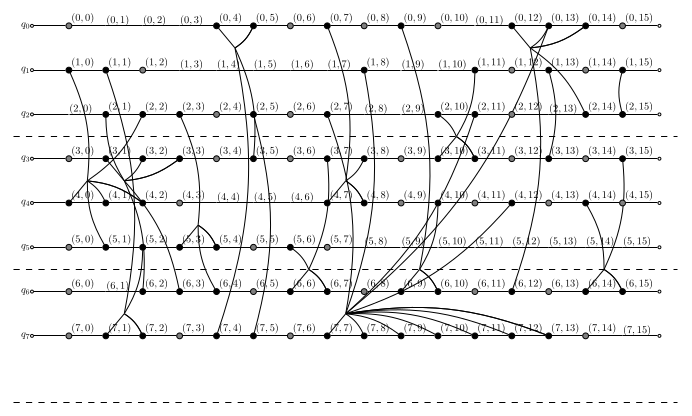

In [2]:
from disqco.drawing.tikz_drawing import draw_graph_tikz
%load_ext jupyter_tikz

draw_graph_tikz(graph, assignment, qpu_sizes)

We first run the normal FM algorithm, with no coarsening, to set a benchmark. We will use the depth of the circuit to calculate the number of passes we will use, for fairness of comparison. We will set a limit on the number of nodes that can be moved per pass.

In [3]:
from disqco.parti.FM.FM_main import run_FM

level_limit = int(np.ceil(np.log2(depth)))

num_passes = (level_limit+1) * 10
move_limit_per_pass = len(graph.nodes)*0.125
exploratory = True

start = time.time()
final_cost, final_assignment, cost_list = run_FM(
    graph,
    assignment,
    qpu_sizes,
    limit=move_limit_per_pass,
    passes=num_passes,
    add_initial=True,
    stochastic=exploratory
)

end = time.time()
print("Final cost: ", final_cost)
print("Time taken: ", end-start)



Final cost:  16
Time taken:  0.10456705093383789


In [4]:
from disqco.parti.FM.multilevel_FM import *
from disqco.graphs.coarsening.coarsener import HypergraphCoarsener

coarsener = HypergraphCoarsener()

initial_graph_full = graph.copy()

graph_list, mapping_list = coarsener.coarsen_full(initial_graph_full, num_levels = depth)

coarsest_graph = graph_list[-1]

print(len(coarsest_graph.nodes))

8


We start by coarsening the graph down to a single time-step, to see how we well can do with static partitioning. The initialisation and termination nodes are included in the figure but are not part of the actual graph.

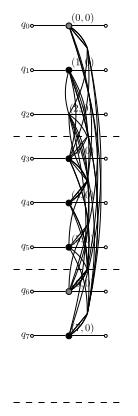

In [5]:
fig = draw_graph_tikz(
    coarsest_graph,
    assignment,
    qpu_sizes
)

display(fig)

In [6]:
start = time.time()
final_cost, final_assignment, cost_list = run_FM(coarsest_graph, assignment, qpu_sizes, limit=move_limit_per_pass, max_gain=4*depth, passes=num_passes, log=False)
end = time.time()

print("Final cost: ", final_cost)

print("Time taken for coarsest graph: ", end-start)


Final cost:  15
Time taken for coarsest graph:  0.02799701690673828


Static partitioning will be much faster, and, in some cases, static partitioning can outperform the fine-grained approach, since the problem size is smaller, but it will often be limited since no state teleportation is possible. We will now look at a multilevel approach using a window-based coarsening routine.

Best cost: 14
Total time: 0.06342077255249023
Drawing figures


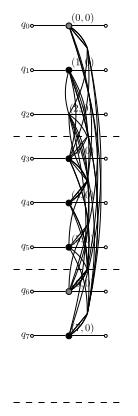

Cost at level 1, 15


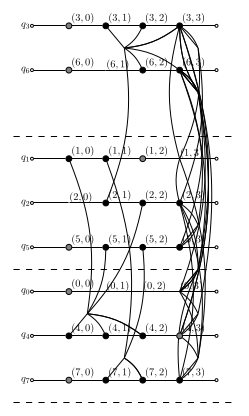

Cost at level 2, 15


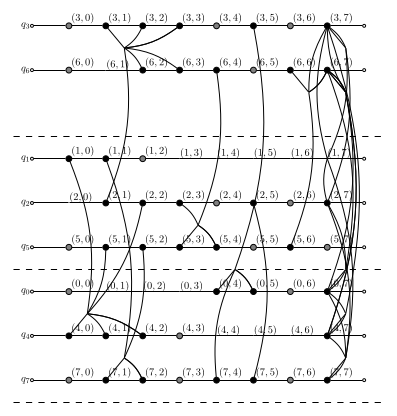

Cost at level 3, 15


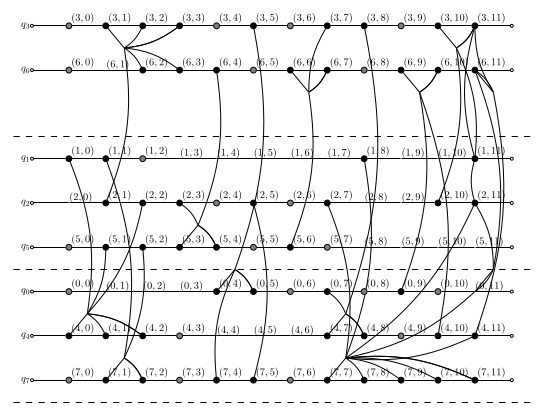

Cost at level 4, 15


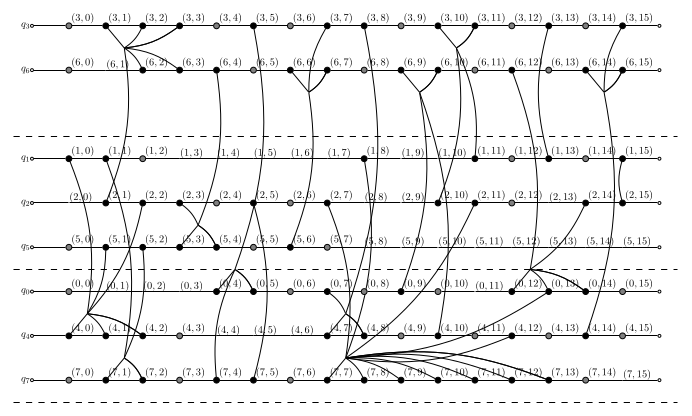

Cost at level 5, 14


In [7]:
initial_graph_window = graph.copy()

graph_list_window, mapping_list_window = coarsener.coarsen_full(initial_graph_window, num_levels = level_limit)


assignment_list_window, cost_list_window, time_list_window = multilevel_FM(graph_list_window, mapping_list_window, assignment, qpu_sizes, limit=move_limit_per_pass, stochastic=exploratory)

best_cost = min(cost_list_window)
total_time = sum(time_list_window)

print(f'Best cost: {best_cost}')
print(f'Total time: {total_time}')

i = 0
print("Drawing figures")
for g in reversed(graph_list_window):
    fig = draw_graph_tikz(
        g,
        assignment_list_window[i],
        qpu_sizes
    )
    display(fig)
    i += 1
    print(f'Cost at level {i}, {calculate_full_cost(g, assignment_list_window[i], num_partitions)}')

Best cost: 13
Total time: 0.066009521484375
Drawing figures


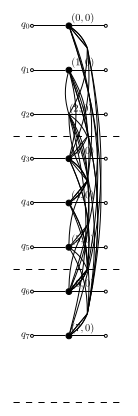

Cost at level 0, 20


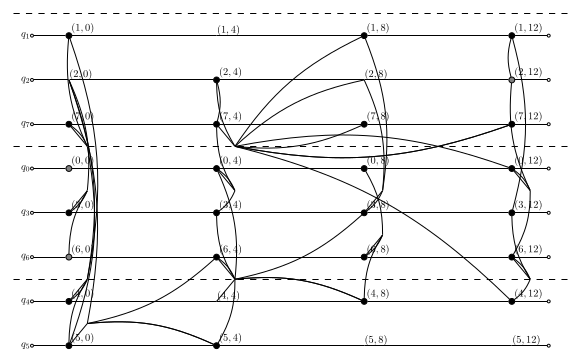

Cost at level 1, 15


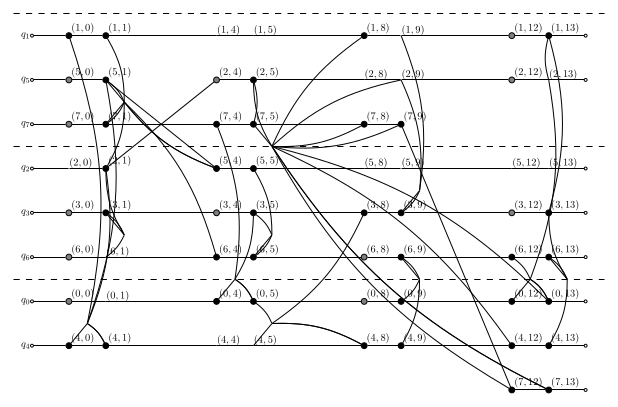

Cost at level 2, 14


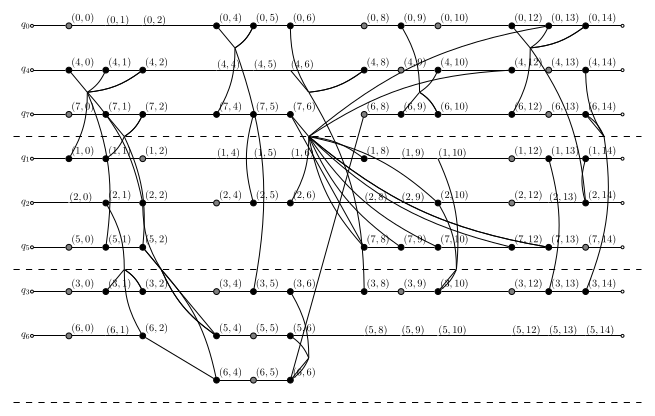

Cost at level 3, 13


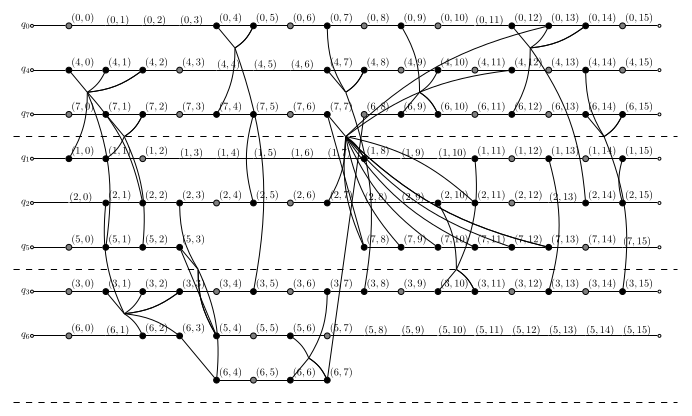

Cost at level 4, 13


In [8]:
initial_graph_blocks = graph.copy()

graph_list_blocks, mapping_list_blocks = coarsener.coarsen_blocks(initial_graph_blocks, num_blocks= None, block_size = level_limit)

assignment_list_blocks, cost_list_blocks, time_list_blocks = multilevel_FM(graph_list_blocks, mapping_list_blocks, assignment, qpu_sizes, limit=move_limit_per_pass, stochastic=exploratory)
i = 0

best_cost = min(cost_list_blocks)
total_time = sum(time_list_blocks)

print(f'Best cost: {best_cost}')
print(f'Total time: {total_time}')

print("Drawing figures")

for g in reversed(graph_list_blocks):
    fig = draw_graph_tikz(
        g,
        assignment_list_blocks[i],
        qpu_sizes
    )
    display(fig)
    print(f'Cost at level {i}, {cost_list_blocks[i]}')
    i += 1

Best cost: 13
Total time: 0.05903911590576172
Drawing figures


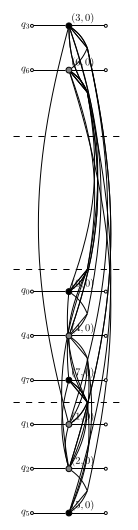

Cost at level 0, 20


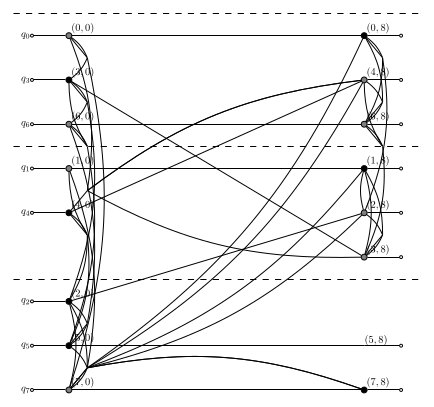

Cost at level 1, 15


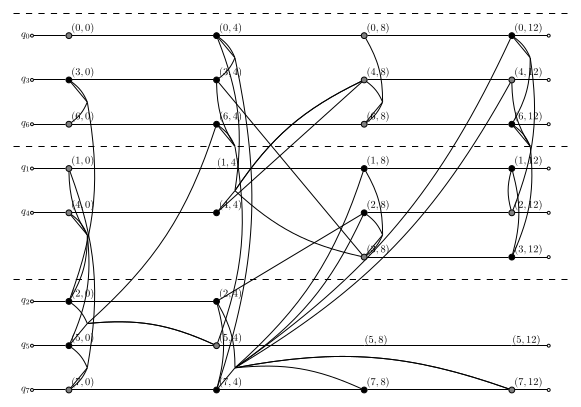

Cost at level 2, 13


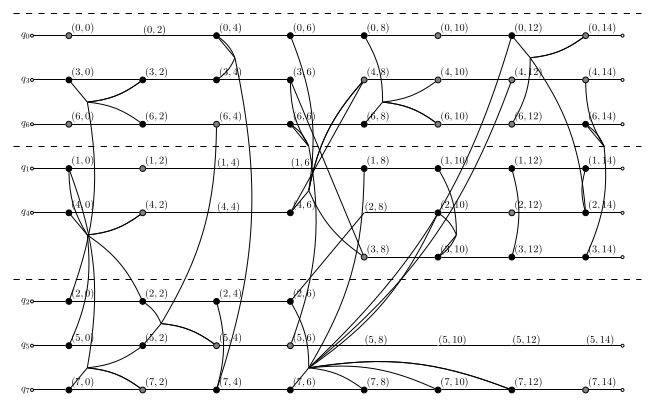

Cost at level 3, 13


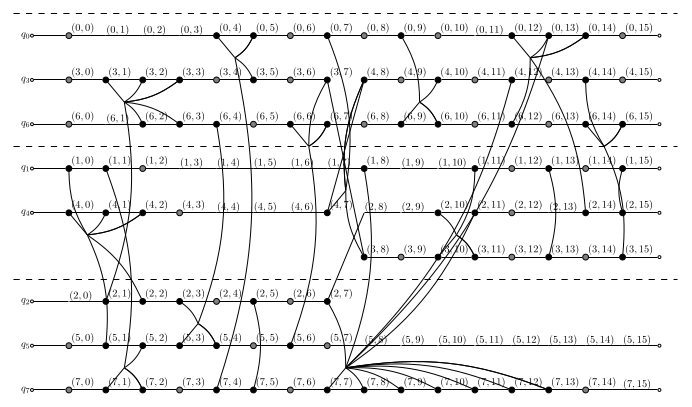

Cost at level 4, 13


In [9]:
from disqco.drawing.tikz_drawing import hypergraph_to_tikz
initial_graph_recursive = graph.copy()
graph_list_recursive, mapping_list_recursive = coarsener.coarsen_recursive_batches_mapped(initial_graph_recursive)

assignment_list_recursive, cost_list_recursive, time_list_recursive = multilevel_FM(graph_list_recursive, mapping_list_recursive, assignment, qpu_sizes, limit=move_limit_per_pass, stochastic=exploratory)
i = 0

best_cost = min(cost_list_recursive)
total_time = sum(time_list_recursive)

print(f'Best cost: {best_cost}')
print(f'Total time: {total_time}')
print("Drawing figures")

tikz_list = []
tikz_list_unoptimised = []

for g in reversed(graph_list_recursive):
    fig = draw_graph_tikz(
        g,
        assignment_list_recursive[i+1],
        qpu_sizes
    )
    tikz_code = hypergraph_to_tikz(g, assignment_list_recursive[i+1], qpu_sizes)
    tikz_list.append(tikz_code)
    

    tikz_code_unoptimised = hypergraph_to_tikz(g, assignment, qpu_sizes)
    tikz_list_unoptimised.append(tikz_code_unoptimised)


    display(fig)
    print(f'Cost at level {i}, {cost_list_recursive[i]}')
    i += 1


In [10]:
for graph_tikz in tikz_list:
    print(graph_tikz)

# for graph_tikz in tikz_list_unoptimised:
#     print(graph_tikz)

\documentclass[tikz,border=2pt]{standalone}
\usepackage{tikz}
\usetikzlibrary{calc,backgrounds}
\pgfdeclarelayer{nodelayer}
\pgfdeclarelayer{edgelayer}
\pgfsetlayers{background,edgelayer,nodelayer,main}
\begin{document}
\begin{tikzpicture}[>=latex, show background rectangle, background rectangle/.style={fill=white}]
  \tikzstyle{whiteSmallStyle}=[circle, draw=black, fill=white, scale=0.15]
  \tikzstyle{blackStyle}=[circle, draw=black, fill=black, scale=0.3]
  \tikzstyle{whiteStyle}=[circle, draw=black, fill=white, scale=0.3]
  \tikzstyle{greyStyle}=[circle, draw=black, fill=gray, scale=0.3]
  \tikzstyle{invisibleStyle}=[inner sep=0pt, scale=0.1, draw=none]
  \tikzstyle{dummyStyle}=[circle, draw=black, fill=blue!20, scale=0.36]
  \tikzset{edgeStyle/.style={draw=black}}
  \tikzset{boundaryLine/.style={draw=black, dashed}}
  \tikzset{nodeLabel/.style={scale=0.5, inner sep=0pt}}
  \begin{pgfonlayer}{nodelayer}
    \node [style=greyStyle, label={[nodeLabel]above right:$(4,0)$}] (n_4_0) at (

[19, 15, 22, 16, 20, 15, 18, 15, 19, 15, 16, 15, 18, 15, 16, 15, 16, 15, 16, 15, 20, 16, 17, 16, 19, 15, 16, 15, 19, 16, 19, 15, 19, 15, 19, 15, 19, 16, 19, 15, 18, 15, 18, 15, 18, 15, 22, 15, 19, 15]
[0, 10, 20, 30, 40, 50]
[20, 15, 15, 16, 15, 15]


Text(0, 0.5, 'Cost')

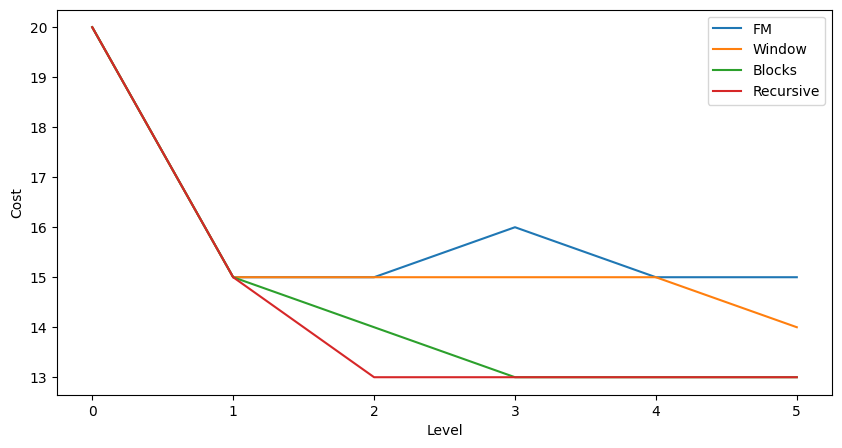

In [11]:
import matplotlib.pyplot as plt

print(cost_list)

cost_list = [initial_cost] + cost_list

index_list = [i*10 for i in range(level_limit+2)]
print(index_list)
cost_list_FM = [cost_list[i*10]for i in range(level_limit+2)]

print(cost_list_FM)

fig, ax = plt.subplots(1, 1, figsize=(10, 5))

plt.plot(cost_list_FM, label = 'FM')
plt.plot(cost_list_window, label = 'Window')
plt.plot(cost_list_blocks, label = 'Blocks')
plt.plot(cost_list_recursive, label = 'Recursive')

plt.legend()
plt.xlabel('Level')
plt.ylabel('Cost')

Text(0, 0.5, 'Time')

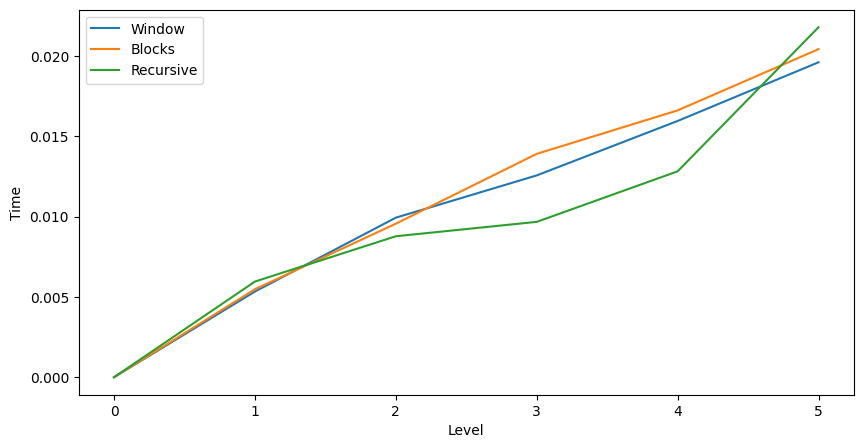

In [12]:
import matplotlib.pyplot as plt



fig, ax = plt.subplots(1, 1, figsize=(10, 5))

plt.plot(time_list_window, label = 'Window')
plt.plot(time_list_blocks, label = 'Blocks')
plt.plot(time_list_recursive, label = 'Recursive')

plt.legend()
plt.xlabel('Level')
plt.ylabel('Time')